In [145]:
import pandas as pd 
import geopandas as gpd
import os   
import matplotlib.pyplot as plt
import matplotlib 
import time 
import ast
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score,  train_test_split
from sklearn import datasets, svm
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [146]:
%%time
# ABRIMOS EL ARCHIVO
data_oscars = pd.read_csv(os.path.join("oscar_award.csv","the_oscar_award.csv"))
data_oscars.head()

Wall time: 35.8 ms


,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False


In [147]:
%%time
# ABRIMOS EL ARCHIVO
data_oscars = pd.read_csv(os.path.join("oscar_award.csv","the_oscar_award.csv"))
# ELIMINAMOS DATOS NULOS
data_oscars = data_oscars.dropna()

# MODIFICAMOS MOMENTANEAMENTE EL NOMBRE PARA PODER GENERAR DATAFRAME
for ind in data_oscars.index:
    film,year = data_oscars['film'][ind],data_oscars['year_film'][ind] 
    data_oscars['film'][ind]=f'{film}[{year}]' 
    
# GENERAMOS UNA LISTA CON CADA PELICULA DISTINTA, DIFERENCIADAS POR SU TITULO Y AÑO PARA NO AGRUPAR REMASTERIZACIONES
movies = []
nominaciones = []
wins = []
for movie in data_oscars['film']:
    if movie not in movies:
        movies.append(movie)

for movie in movies:
    nomin = len(data_oscars[data_oscars['film']==movie])
    nominaciones.append(nomin)
    ganadas = len(data_oscars[(data_oscars['film']==movie)&(data_oscars['winner']==True)])
    wins.append(ganadas)

# GENERAMOS DATAFRAME
diccionario_df = {'Pelicula': movies, 'Nominaciones': nominaciones, 'Premios': wins} 

df = pd.DataFrame(diccionario_df)
#ese es de las nominaciones
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Wall time: 22 s


,Pelicula,Nominaciones,Premios
0,The Noose[1927],1,0
1,The Last Command[1927],2,1
2,A Ship Comes In[1927],1,0
3,7th Heaven[1927],5,3
4,Sadie Thompson[1927],1,0


In [148]:
%%time
data_ratings = pd.read_csv(os.path.join("ratings_small.csv","ratings_small.csv"))

movies_id = []
ratings = []
cant_ratings = []
for Id in data_ratings['movieId'].unique():
    movies_id.append(Id)
    ratings.append(round(data_ratings[data_ratings['movieId']==Id]['rating'].mean(),1))
    cant_ratings.append(len(data_ratings[data_ratings['movieId']==Id]))

diccionario_ratings = {'IdPelicula': movies_id, 'RatingProm': ratings, 'Cant_Ratings': cant_ratings} 

df_ratings = pd.DataFrame(diccionario_ratings)
df_ratings.head()

Wall time: 15.1 s


,IdPelicula,RatingProm,Cant_Ratings
0,31,3.2,42
1,1029,3.7,42
2,1061,3.5,33
3,1129,3.3,48
4,1172,4.3,46


In [149]:
data_movies = pd.read_csv(os.path.join("movies_metadata.csv","movies_metadata.csv"))
data_movies.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [150]:
# Ocupamos ciertas columnas con las cuales se trabajaran
columns = ['title', 'original_title', 'genres', 'id', 'imdb_id', 'original_language', 'popularity', 'release_date', 'production_countries', 'runtime']
data_movies = data_movies[columns]
#Eliminamos los datos Nulos 
data_movies = data_movies.dropna()
# eliminamos todas las peliculas que no tengan genero
data_movies = data_movies.drop(data_movies[data_movies['genres']== '[]'].index)
# cambiamos el id a int ya que haremos un merge y en el otro dataset se encuentra como variable int64
data_movies['id'] = data_movies['id'].astype('int64')
data_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42797 entries, 0 to 45463
Data columns (total 10 columns):
title                   42797 non-null object
original_title          42797 non-null object
genres                  42797 non-null object
id                      42797 non-null int64
imdb_id                 42797 non-null object
original_language       42797 non-null object
popularity              42797 non-null object
release_date            42797 non-null object
production_countries    42797 non-null object
runtime                 42797 non-null float64
dtypes: float64(1), int64(1), object(8)
memory usage: 3.6+ MB


In [151]:
# Merge entre las peliculas y sus ratings
movie_ratings = pd.merge(data_movies, df_ratings, left_on = 'id', right_on = 'IdPelicula', how = 'left')
movie_ratings = movie_ratings.dropna().reset_index(drop=True)
# cambiamos a datetime la columna release_date
movie_ratings.release_date = pd.to_datetime(movie_ratings['release_date'])
# obtenemos el ano de esta columna datetime
movie_ratings["year"] = movie_ratings.release_date.dt.year
print(movie_ratings.shape)
movie_ratings.sort_values('year').head()
# no se ocupa ya que son pocos los datos que quedan luego de hacer el merge

(2798, 14)


,title,original_title,genres,id,imdb_id,original_language,popularity,release_date,production_countries,runtime,IdPelicula,RatingProm,Cant_Ratings,year
2243,The Arrival of a Train at La Ciotat,L'arrivée d'un train en gare de La Ciotat,"[{'id': 99, 'name': 'Documentary'}]",160,tt0000012,es,5.25661,1896-01-25,"[{'iso_3166_1': 'FR', 'name': 'France'}]",1.0,160.0,2.3,63.0,1896
2797,The One-Man Band,L'Homme orchestre,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...",49280,tt0135453,fr,1.109068,1900-01-01,"[{'iso_3166_1': 'FR', 'name': 'France'}]",1.0,49280.0,5.0,1.0,1900
1508,A Trip to the Moon,Le Voyage dans la Lune,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",775,tt0000417,fr,6.3218,1902-09-01,"[{'iso_3166_1': 'FR', 'name': 'France'}]",14.0,775.0,2.0,1.0,1902
2785,Extraordinary Illusions,Illusions funambulesques,"[{'id': 35, 'name': 'Comedy'}]",127098,tt0223509,fr,0.141611,1903-01-01,"[{'iso_3166_1': 'FR', 'name': 'France'}]",2.0,127098.0,4.0,1.0,1903
2202,Frankenstein,Frankenstein,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",2929,tt0001223,en,1.65988,1910-03-18,"[{'iso_3166_1': 'US', 'name': 'United States o...",13.0,2929.0,3.9,14.0,1910


In [152]:
# por lo tanto ocupamos otro dataset en donde tienen mas calificaciones de usuarios para las peliculas
data_ratings_externo = pd.read_csv(os.path.join("ratings_externo","IMDb ratings.csv"))
# columnas que nos serviran
columnas = ['imdb_title_id', 'weighted_average_vote', 'total_votes', 'mean_vote']
data_ratings_externo = data_ratings_externo[columnas]
data_ratings_externo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 4 columns):
imdb_title_id            85855 non-null object
weighted_average_vote    85855 non-null float64
total_votes              85855 non-null int64
mean_vote                85855 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.6+ MB


In [153]:
# hacemos el merge como antes pero ahora relacionandolo con el imdb_id de cada pelicula
movie_ratings_2 = pd.merge(data_movies, data_ratings_externo, left_on = 'imdb_id', right_on = 'imdb_title_id', how = 'left')
movie_ratings_2 = movie_ratings_2.dropna().reset_index(drop=True)
# convertimos a datetime la columna 'release_date'
movie_ratings_2.release_date = pd.to_datetime(movie_ratings_2['release_date'])
# obtenemos el ano de esto 
movie_ratings_2["year"] = movie_ratings_2.release_date.dt.year
# hacemos una limpieza de los anos, ya que sera comparado con los oscars y estos toman las peliculas desde el ano 1927 
movie_ratings_2 = movie_ratings_2.drop(movie_ratings_2[movie_ratings_2['year'] < 1927].index)
# se puede ver que perdimos menos registros con este dataset, por lo tanto nos quedaremos con el 
print(movie_ratings_2.shape)
movie_ratings_2.head()

(32580, 15)


,title,original_title,genres,id,imdb_id,original_language,popularity,release_date,production_countries,runtime,imdb_title_id,weighted_average_vote,total_votes,mean_vote,year
0,Toy Story,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,21.9469,1995-10-30,"[{'iso_3166_1': 'US', 'name': 'United States o...",81.0,tt0114709,8.3,864461.0,8.3,1995
1,Jumanji,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,17.0155,1995-12-15,"[{'iso_3166_1': 'US', 'name': 'United States o...",104.0,tt0113497,7.0,299083.0,7.1,1995
2,Grumpier Old Men,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,en,11.7129,1995-12-22,"[{'iso_3166_1': 'US', 'name': 'United States o...",101.0,tt0113228,6.7,23742.0,6.8,1995
3,Waiting to Exhale,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,3.85949,1995-12-22,"[{'iso_3166_1': 'US', 'name': 'United States o...",127.0,tt0114885,5.9,9353.0,6.2,1995
4,Father of the Bride Part II,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,en,8.38752,1995-02-10,"[{'iso_3166_1': 'US', 'name': 'United States o...",106.0,tt0113041,6.1,33587.0,6.2,1995


In [154]:
# necesitamos los generos para crear un dataframe y hacer un grafico para lograr hacer un analisis de los datos 
genres = movie_ratings_2['genres']
genre_movie = []
generos_totales = []
for i in genres:
    genre = ''
    generos_pelicula = i.split("'")[5::6]
    for j in generos_pelicula:
        if j not in generos_totales:
            generos_totales.append(j)
    for x in range(len(generos_pelicula)):
        if x < len(generos_pelicula) -1:
            genre+=f'{generos_pelicula[x]},'
        else:
            genre+=generos_pelicula[x]
    genre_movie.append(genre)
movie_ratings_2['genres'] = genre_movie

In [155]:
# creamos un dataframe con todos los generos y cada columna si tiene un 0 quiere decir que la pelicula no pertenece a ese genero, si tiene un 1 quiere decir que pertenece la pelicula a ese genero
df_genre = pd.DataFrame()
for genre in generos_totales:
    df_genre[genre] = movie_ratings_2['genres'].str.contains(genre).map(lambda x:1 if x else 0)
# a este data frame le agregaremos el ano para poder hacer una comparacion de cuantas peliculas por ano se filman para cada genero 
df_genre['year'] = movie_ratings_2["year"]
# hacemos groupby segun el ano para ver las cta de peliculas
genero_peliculas_ano = df_genre.groupby('year').sum()
# hacemos sort para ver el grafico en orden
genero_peliculas_ano_sumados = genero_peliculas_ano.sum().sort_values(ascending=False)

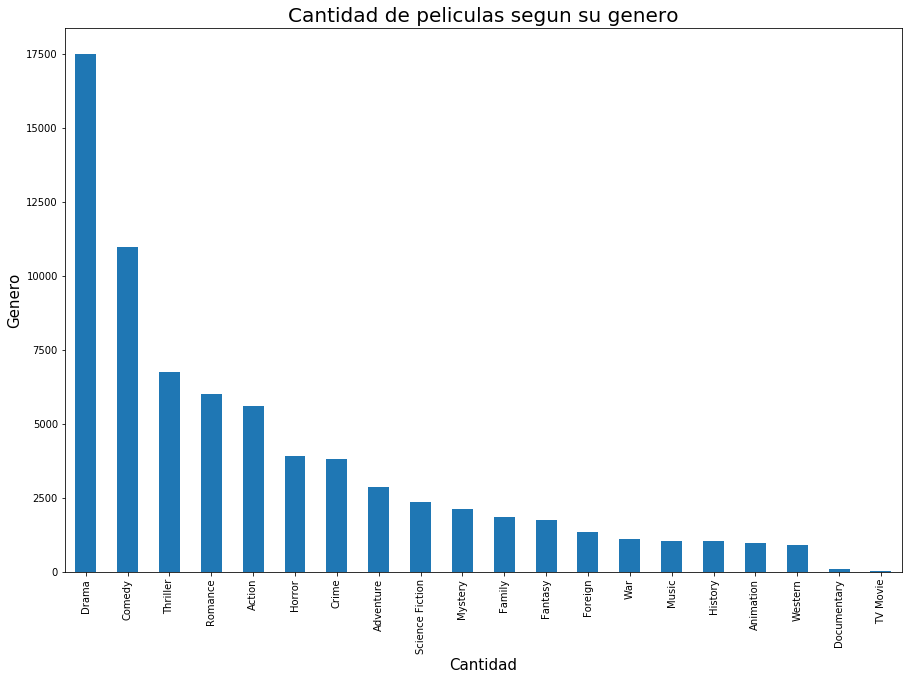

In [156]:
#grafico de cuantas peliculas se generan 
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(1,1,1)
# un grafico de barras para que sea mas descriptivo y facil de analizar
ax = genero_peliculas_ano_sumados.plot.bar()
plt.xticks(rotation=90)
plt.title('Cantidad de peliculas segun su genero', fontsize = 20)
plt.ylabel('Genero', fontsize = 15)
plt.xlabel('Cantidad', fontsize = 15)
plt.show()

In [157]:
%%time
paises = []
for ind in movie_ratings_2['production_countries'].index:
    x = ast.literal_eval(movie_ratings_2['production_countries'][ind])
    if len(x) > 0:
        countries = []
        countries_str = ''
        for dat in x:
            pais = dat['name']
            countries.append(dat['name'])
            countries_str += f'{pais},'
            if dat['name'] not in paises:
                paises.append(dat['name'])
    #movie_ratings_2['production_countries'][ind] = countries
    movie_ratings_2['production_countries'][ind] = countries_str


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Wall time: 12.5 s


In [158]:
# hacemos el mismo analisis hecho anteriormente, pero ahora con los paises, veremos cuanta produccion de peliculas tiene cada pais 
df_countries = pd.DataFrame()
for pais in paises:
    df_countries[pais] = movie_ratings_2['production_countries'].str.contains(pais).map(lambda x:1 if x else 0)

In [159]:
# a este data frame le agregaremos el ano para poder hacer una comparacion de cuantas peliculas se filman en un pais
df_countries['year'] = movie_ratings_2["year"]
# hacemos groupby segun el ano para ver las cta de peliculas por pais
peliculas_pais_ano = df_countries.groupby('year').sum()
# hacemos sort para ver el grafico en orden
peliculas_pais_ano_sumados = peliculas_pais_ano.sum().sort_values(ascending=False)


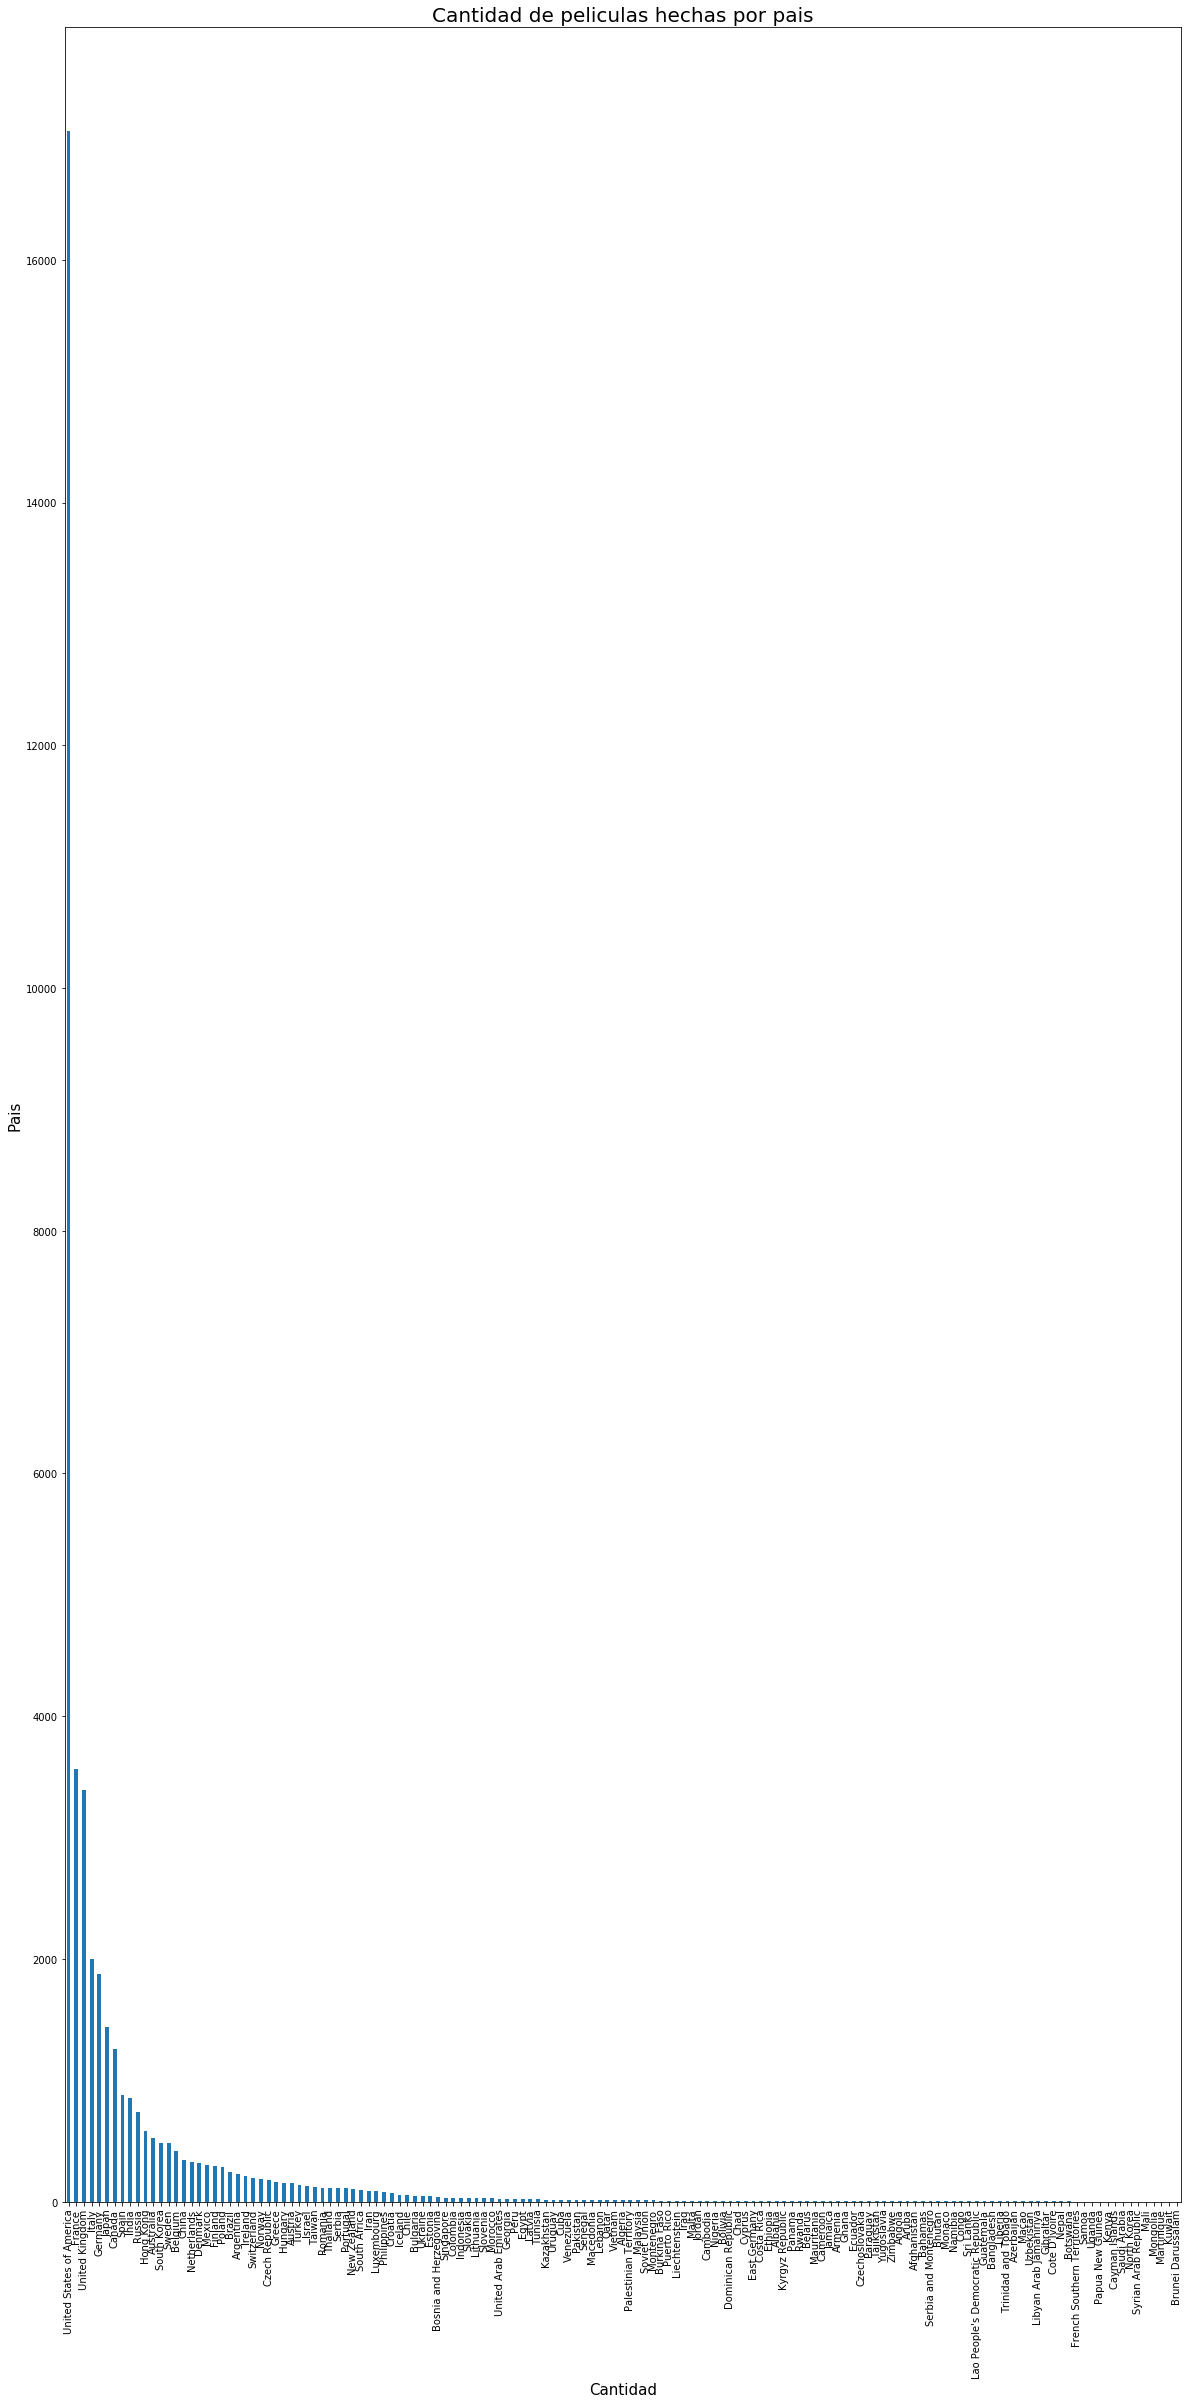

In [160]:
#grafico de cuantas peliculas en un pais se generan
fig = plt.figure(figsize=(20,40))
ax = plt.subplot(1,1,1)
# un grafico de barras para que sea mas descriptivo y facil de analizar
ax = peliculas_pais_ano_sumados.plot.bar()
plt.xticks(rotation=90)
plt.title('Cantidad de peliculas hechas por pais', fontsize = 20)
plt.ylabel('Pais', fontsize = 15)
plt.xlabel('Cantidad', fontsize = 15)
plt.show()

In [161]:
df_paises_cta = pd.DataFrame(peliculas_pais_ano_sumados, columns= ['Cantidad'])
df_paises_cta = df_paises_cta.rename_axis('Paises').reset_index()
df_paises_cta.head()


,Paises,Cantidad
0,United States of America,17063
1,France,3566
2,United Kingdom,3391
3,Italy,2003
4,Germany,1880


In [162]:
"""
Descargamos geodataset para relacionar país con calidad y recepción de producciones.
Sjoin debe ser por columna "sovereight"
"""
url = 'https://data.opendatasoft.com/explore/dataset/natural-earth-countries-1_110m@public/download/?format=geojson&timezone=America/Santo_Domingo&lang=en'
gdf_paises = gpd.read_file(url)
columnas = ['sovereignt', 'geometry']
gdf_paises = gdf_paises[columnas]
gdf_paises.head()

,sovereignt,geometry
0,Haiti,"POLYGON ((-71.71236 19.71446, -71.62487 19.169..."
1,Ghana,"POLYGON ((0.02380 11.01868, -0.04978 10.70692,..."
2,Jordan,"POLYGON ((35.54567 32.39399, 35.71992 32.70919..."
3,Myanmar,"POLYGON ((100.11599 20.41785, 99.54331 20.1866..."
4,Bhutan,"POLYGON ((91.69666 27.77174, 92.10371 27.45261..."


In [163]:
df_paises_cta = pd.merge(df_paises_cta, gdf_paises, left_on = 'Paises', right_on = 'sovereignt', how = 'right')
df_paises_cta = df_paises_cta.dropna().reset_index(drop=True)
gdf_paises_cta = gpd.GeoDataFrame(df_paises_cta, crs="EPSG:4326", geometry=df_paises_cta['geometry'])
gdf_paises_cta = gdf_paises_cta.drop(['sovereignt'], axis=1)
gdf_paises_cta.head()

,Paises,Cantidad,geometry
0,United States of America,17063.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
1,United States of America,17063.0,"POLYGON ((-66.28243 18.51476, -65.77130 18.426..."
2,France,3566.0,"POLYGON ((68.93500 -48.62500, 69.58000 -48.940..."
3,France,3566.0,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3..."
4,France,3566.0,"POLYGON ((165.77999 -21.08000, 166.59999 -21.7..."


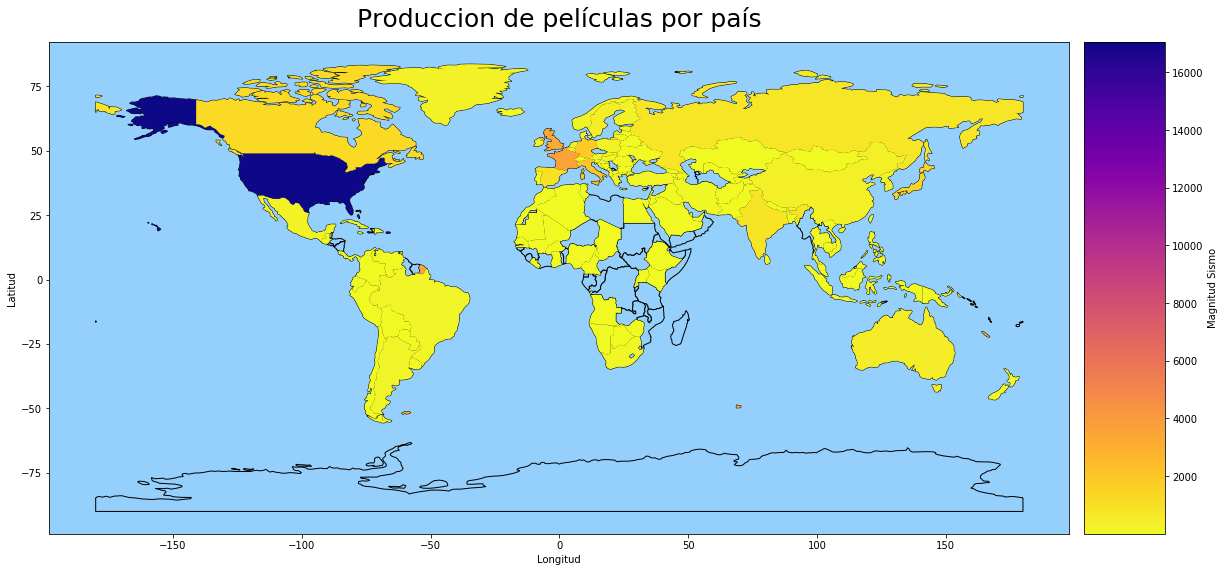

In [196]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
world.plot(ax=ax, color='xkcd:light blue', edgecolor='black')
ax.set_title('Produccion de películas por país', pad = 15, 
             fontdict={'fontsize':25, 'color': '#000000'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_facecolor('xkcd:light blue')
# Añadir la leyenda 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.2)
gdf_paises_cta.plot(column='Cantidad', cmap='plasma_r', ax=ax,legend=True, cax=cax,
         legend_kwds={'label': "Magnitud Sismo",'orientation': "vertical"})
plt.show()
#fig.savefig('mapa_cta.png',bbox_inches='tight')

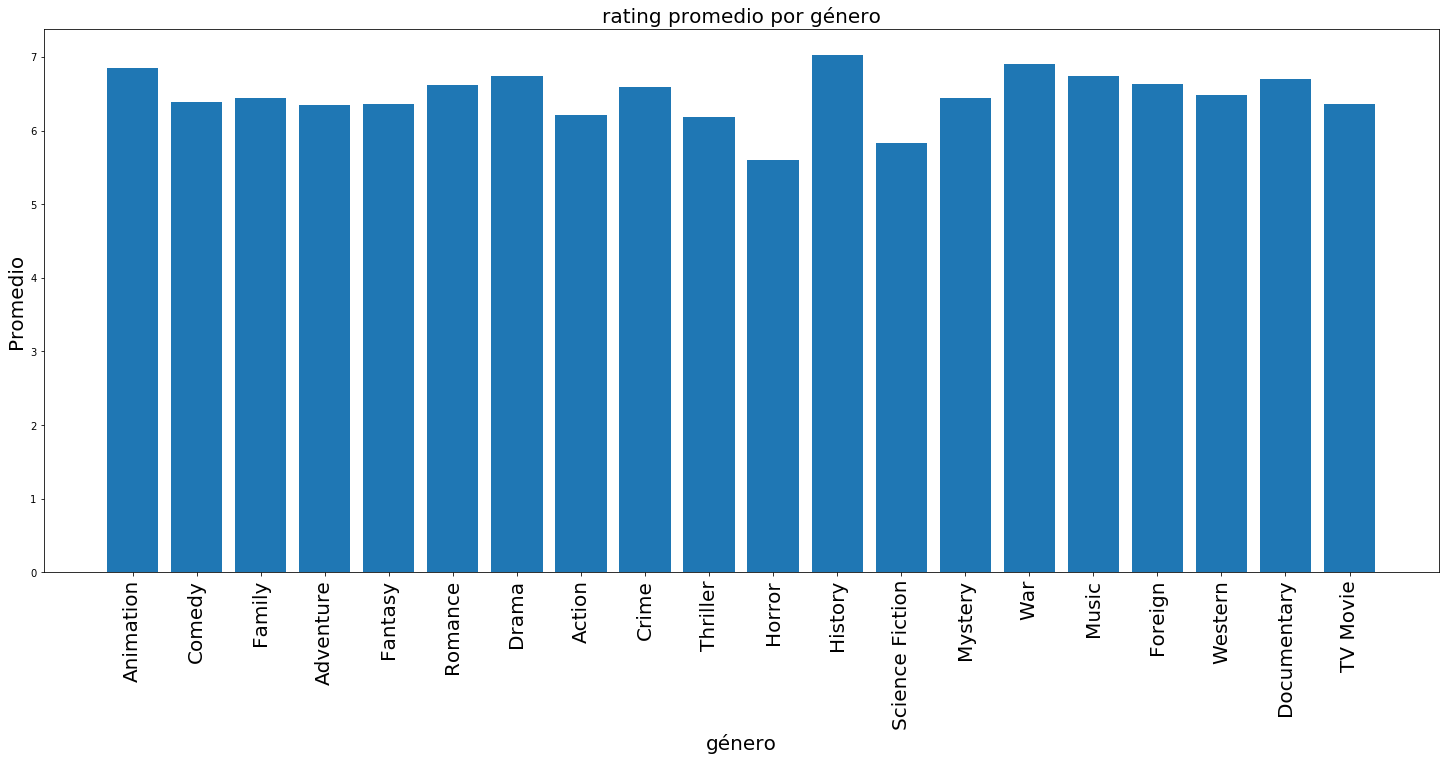

1.859327793121338


In [165]:
start = time.time()
genres = {}
for genre in movie_ratings_2['genres']:
    for g in genre.split(','):
        if g not in genres:
            genres[g] = []

for ind in movie_ratings_2.index:
    gen = movie_ratings_2['genres'][ind].split(',')
    for g in gen:
        genres[g].append(movie_ratings_2['mean_vote'][ind])

for genre in genres:
    genres[genre] = sum(genres[genre])/len(genres[genre])

names = list(genres.keys())
values = list(genres.values())

fig = plt.figure(figsize=(25,10))
plt.bar(range(len(genres)), values, tick_label=names)
plt.xticks(rotation=90, fontsize = 20)
plt.title('rating promedio por género', fontsize = 20)
plt.ylabel('Promedio', fontsize = 20)
plt.xlabel('género', fontsize = 20)
plt.show()
end = time.time()
print(end - start)

In [166]:
# ocupamos tittle y el ano para poder hacer merge con el dataset de los oscars 
title = movie_ratings_2['title'].to_list()
ano = movie_ratings_2['year'].to_list()
pelicula_ano = []
for i in range(len(title)):
    movie= title[i]
    year = ano[i]
    movie_year = f'{movie}[{year}]'
    pelicula_ano.append(movie_year)
movie_ratings_2['Pelicula'] = pelicula_ano
columns = ['Pelicula','runtime','genres','mean_vote']
movies_ratings_2_merge = movie_ratings_2[columns]
movies_ratings_2_merge.head()

,Pelicula,runtime,genres,mean_vote
0,Toy Story[1995],81.0,"Animation,Comedy,Family",8.3
1,Jumanji[1995],104.0,"Adventure,Fantasy,Family",7.1
2,Grumpier Old Men[1995],101.0,"Romance,Comedy",6.8
3,Waiting to Exhale[1995],127.0,"Comedy,Drama,Romance",6.2
4,Father of the Bride Part II[1995],106.0,Comedy,6.2


In [167]:
# hacemos el merge segun el title con los oscars
movie_oscars = pd.merge(movies_ratings_2_merge, df, left_on = 'Pelicula', right_on = 'Pelicula', how = 'left')
movie_oscars = movie_oscars.dropna().reset_index(drop=True)
print(movie_oscars.shape)
movie_oscars.sort_values('Nominaciones', ascending = False).head()

(2447, 6)


,Pelicula,runtime,genres,mean_vote,Nominaciones,Premios
335,Titanic[1997],194.0,"Drama,Romance,Thriller",7.8,14.0,11.0
2409,La La Land[2016],128.0,"Comedy,Drama,Music,Romance",7.9,14.0,6.0
995,Chicago[2002],113.0,"Action,Comedy,Crime,Drama,Music",7.3,13.0,6.0
888,The Lord of the Rings: The Fellowship of the R...,178.0,"Adventure,Fantasy,Action",8.7,13.0,4.0
141,Gone with the Wind[1939],238.0,"Drama,Romance,War",8.1,13.0,8.0


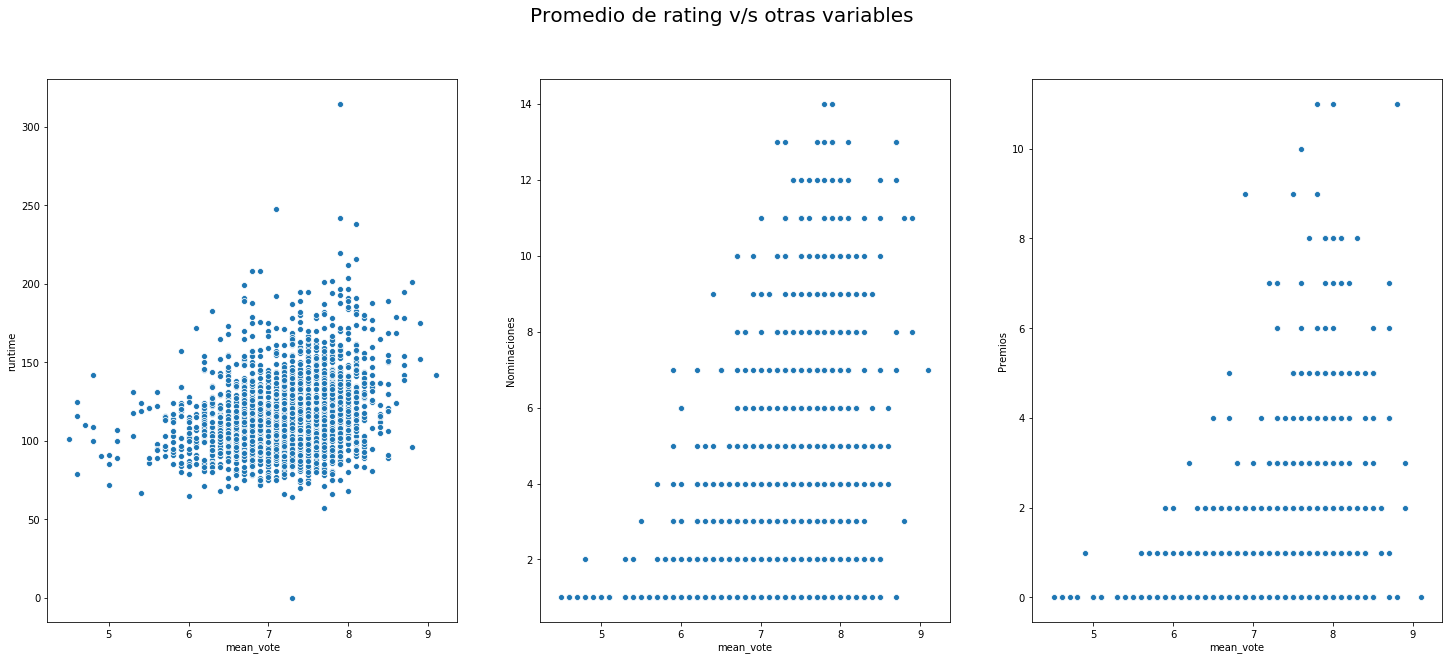

In [168]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(25,10))
fig.suptitle('Promedio de rating v/s otras variables', size=(20))

sns.scatterplot(ax = axes[0], data=movie_oscars, x="mean_vote", y='runtime')


sns.scatterplot(ax = axes[1], data=movie_oscars, x="mean_vote", y='Nominaciones')


sns.scatterplot(ax = axes[2], data=movie_oscars, x="mean_vote", y='Premios')
#fig.savefig('Buen_cine.png',bbox_inches='tight')

In [169]:
print(movie_oscars.shape)
movie_oscars.head()

(2447, 6)


,Pelicula,runtime,genres,mean_vote,Nominaciones,Premios
0,Toy Story[1995],81.0,"Animation,Comedy,Family",8.3,3.0,0.0
1,Sabrina[1995],127.0,"Comedy,Romance",6.5,2.0,0.0
2,The American President[1995],106.0,"Comedy,Drama,Romance",7.0,1.0,0.0
3,Nixon[1995],192.0,"History,Drama",7.1,4.0,0.0
4,Casino[1995],178.0,"Drama,Crime",8.2,1.0,0.0


In [170]:
print(movie_ratings_2.shape)
movie_ratings_2.head()

(32580, 16)


,title,original_title,genres,id,imdb_id,original_language,popularity,release_date,production_countries,runtime,imdb_title_id,weighted_average_vote,total_votes,mean_vote,year,Pelicula
0,Toy Story,Toy Story,"Animation,Comedy,Family",862,tt0114709,en,21.9469,1995-10-30,"United States of America,",81.0,tt0114709,8.3,864461.0,8.3,1995,Toy Story[1995]
1,Jumanji,Jumanji,"Adventure,Fantasy,Family",8844,tt0113497,en,17.0155,1995-12-15,"United States of America,",104.0,tt0113497,7.0,299083.0,7.1,1995,Jumanji[1995]
2,Grumpier Old Men,Grumpier Old Men,"Romance,Comedy",15602,tt0113228,en,11.7129,1995-12-22,"United States of America,",101.0,tt0113228,6.7,23742.0,6.8,1995,Grumpier Old Men[1995]
3,Waiting to Exhale,Waiting to Exhale,"Comedy,Drama,Romance",31357,tt0114885,en,3.85949,1995-12-22,"United States of America,",127.0,tt0114885,5.9,9353.0,6.2,1995,Waiting to Exhale[1995]
4,Father of the Bride Part II,Father of the Bride Part II,Comedy,11862,tt0113041,en,8.38752,1995-02-10,"United States of America,",106.0,tt0113041,6.1,33587.0,6.2,1995,Father of the Bride Part II[1995]


In [171]:
# hacemos el merge segun la Peliculacon los oscars
columns = ['Pelicula','runtime','genres','mean_vote', 'year']
movie_lr = movie_ratings_2[columns]
movie_oscars_lr = pd.merge(movie_lr, df, left_on = 'Pelicula', right_on = 'Pelicula', how = 'left')
movie_oscars_lr.sort_values('mean_vote', ascending = False).head()
movie_oscars_lr.fillna(0, inplace=True)
movie_oscars_lr.head()

,Pelicula,runtime,genres,mean_vote,year,Nominaciones,Premios
0,Toy Story[1995],81.0,"Animation,Comedy,Family",8.3,1995,3.0,0.0
1,Jumanji[1995],104.0,"Adventure,Fantasy,Family",7.1,1995,0.0,0.0
2,Grumpier Old Men[1995],101.0,"Romance,Comedy",6.8,1995,0.0,0.0
3,Waiting to Exhale[1995],127.0,"Comedy,Drama,Romance",6.2,1995,0.0,0.0
4,Father of the Bride Part II[1995],106.0,Comedy,6.2,1995,0.0,0.0


In [172]:
# ocupamos la lista generos creada anteriormente.
df_genre = pd.DataFrame()
for genre in generos_totales:
    df_genre[genre] = movie_oscars_lr['genres'].str.contains(genre).map(lambda x:1 if x else 0)
movie_oscars_lr = movie_oscars_lr.join(df_genre) #unir los generos con el movie_oscars_lr columans de 1 y 0
movie_oscars_lr.head()


,Pelicula,runtime,genres,mean_vote,year,Nominaciones,Premios,Animation,Comedy,Family,...,Horror,History,Science Fiction,Mystery,War,Music,Foreign,Western,Documentary,TV Movie
0,Toy Story[1995],81.0,"Animation,Comedy,Family",8.3,1995,3.0,0.0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,Jumanji[1995],104.0,"Adventure,Fantasy,Family",7.1,1995,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Grumpier Old Men[1995],101.0,"Romance,Comedy",6.8,1995,0.0,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Waiting to Exhale[1995],127.0,"Comedy,Drama,Romance",6.2,1995,0.0,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Father of the Bride Part II[1995],106.0,Comedy,6.2,1995,0.0,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [173]:
movie_oscars_lr=movie_oscars_lr.drop(['genres'], axis=1)

In [174]:
movie_oscars_lr.head()

,Pelicula,runtime,mean_vote,year,Nominaciones,Premios,Animation,Comedy,Family,Adventure,...,Horror,History,Science Fiction,Mystery,War,Music,Foreign,Western,Documentary,TV Movie
0,Toy Story[1995],81.0,8.3,1995,3.0,0.0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Jumanji[1995],104.0,7.1,1995,0.0,0.0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,Grumpier Old Men[1995],101.0,6.8,1995,0.0,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Waiting to Exhale[1995],127.0,6.2,1995,0.0,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Father of the Bride Part II[1995],106.0,6.2,1995,0.0,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
col = [i for i in movie_oscars_lr if i not in ['Pelicula', 'mean_vote']]

x = movie_oscars_lr[col]
y = movie_oscars_lr['mean_vote']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

lr = LinearRegression(normalize = True)
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [176]:
true = y_test.values
pred = lr.predict(x_test)

In [177]:
%%time
# RMSE
((true-pred)**2).mean()

Wall time: 1.01 ms


0.7336286426692399

In [178]:
%%time
mean_squared_error(true, pred)

Wall time: 1.01 ms


0.7336286426692399

In [179]:
from sklearn.metrics import mean_absolute_error

In [180]:
%%time
mean_absolute_error(true, pred)

Wall time: 1 ms


0.6562521024403449

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


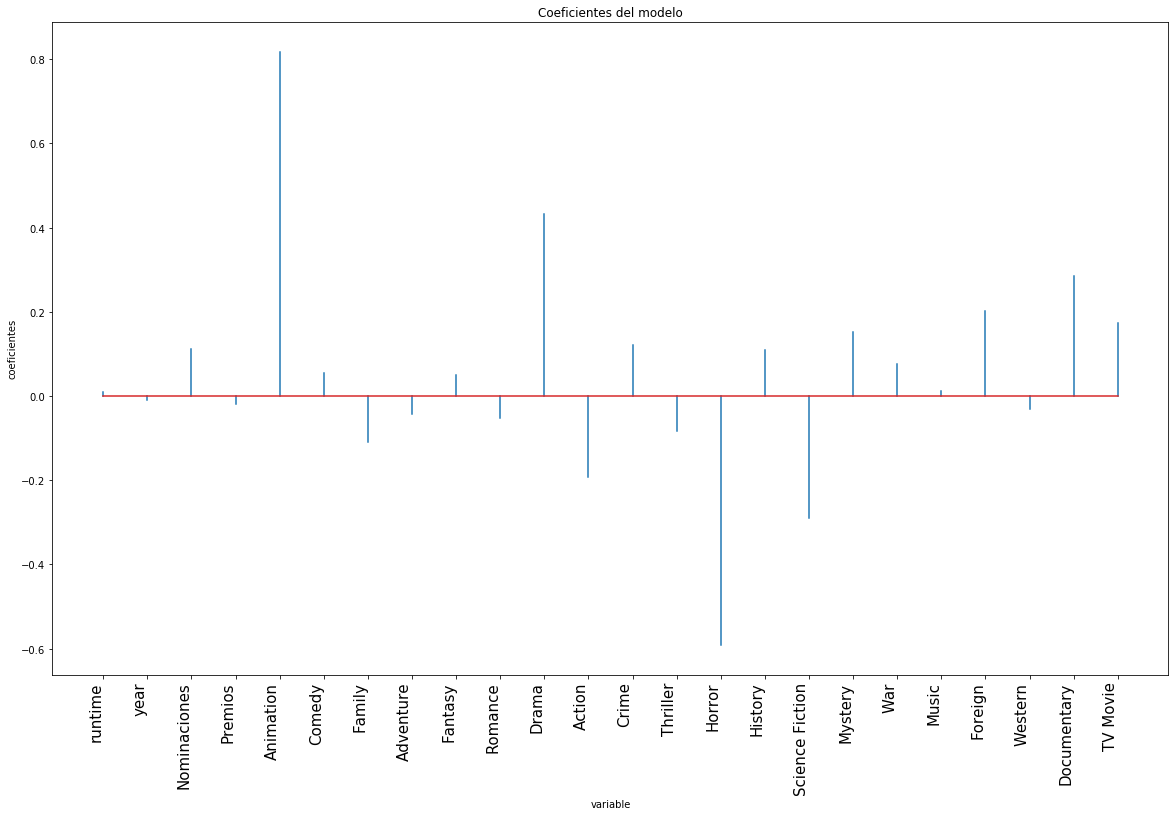

In [181]:
df_coeficientes = pd.DataFrame(
                        {'predictor': x_train.columns,
                         'coef': lr.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(20, 12))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=15)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [182]:
import numpy as np

In [183]:
modelo = RidgeCV(
            alphas          = np.logspace(-10, 2, 200),
            fit_intercept   = True,
            normalize       = True,
            store_cv_values = True
         )

_ = modelo.fit(X = x_train, y = y_train)

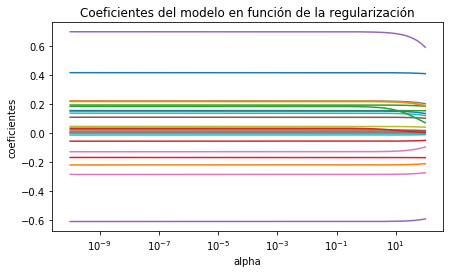

In [184]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(x_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

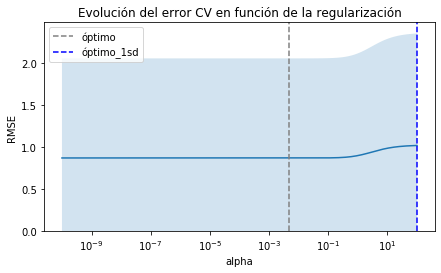

In [185]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.cv_values almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_samples, n_targets, n_alphas)
mse_cv = modelo.cv_values_.reshape((-1, 200)).mean(axis=0)
mse_sd = modelo.cv_values_.reshape((-1, 200)).std(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas[rmse_cv == min_rsme_1sd]


# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas, rmse_cv)
ax.fill_between(
    modelo.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [186]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 0.004552935074866948


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if __name__ == '__main__':


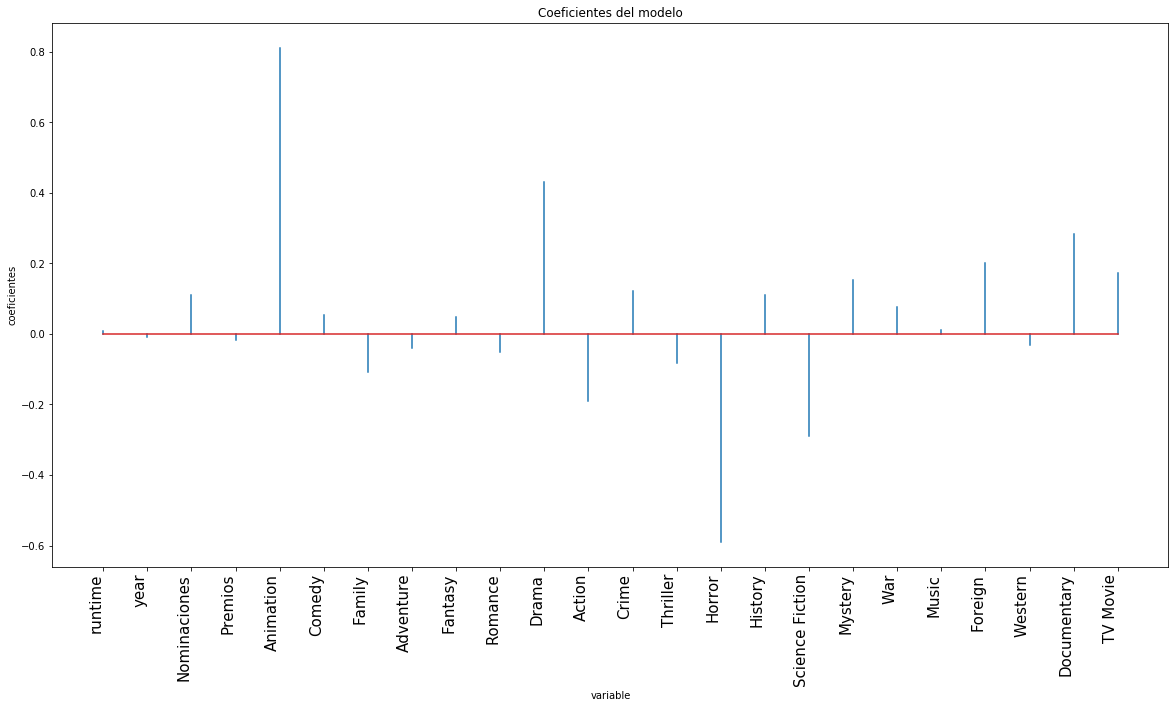

In [187]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': x_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=15)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [188]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': x_train.columns,
                         'coef': lr.coef_.flatten()}
                  )

# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
0,runtime,0.008592
1,year,-0.008433
2,Nominaciones,0.111353
3,Premios,-0.018263
4,Animation,0.817489
5,Comedy,0.055531
6,Family,-0.109731
7,Adventure,-0.041387
8,Fantasy,0.049793
9,Romance,-0.051465


In [189]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': x_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
0,runtime,0.008551
1,year,-0.008387
2,Nominaciones,0.110625
3,Premios,-0.016193
4,Animation,0.811497
5,Comedy,0.054276
6,Family,-0.108085
7,Adventure,-0.041271
8,Fantasy,0.049273
9,Romance,-0.050223


In [190]:
# Verificacion de las metricas para ver si nuestro modelo va por buen camino
metricas_cv = cross_validate(lr, x, y, cv=5,
                        scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True)
test_r2 = np.mean(metricas_cv['test_r2'])
train_r2 = np.mean(metricas_cv['train_r2'])
mse_test = -(np.mean(metricas_cv['test_neg_mean_squared_error']))
mse_train = -(np.mean(metricas_cv['train_neg_mean_squared_error']))
print(f'----Linear Regresion----')
print(f'R2[Test]: {test_r2}')
print(f'R2[Train]: {train_r2}')
print(f'MSE[Test]: {mse_test}')
print(f'MSE[Train]: {mse_train}')

----Linear Regresion----
R2[Test]: 0.22928803961083144
R2[Train]: 0.2822491617089652
MSE[Test]: 0.7709886421794435
MSE[Train]: 0.7489500577803656


In [191]:
# Verificacion de las metricas para ver si nuestro modelo va por buen camino
metricas_cv = cross_validate(modelo, x, y, cv=5,
                        scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True)
test_r2 = np.mean(metricas_cv['test_r2'])
train_r2 = np.mean(metricas_cv['train_r2'])
mse_test = -(np.mean(metricas_cv['test_neg_mean_squared_error']))
mse_train = -(np.mean(metricas_cv['train_neg_mean_squared_error']))
print(f'------Ridge Regresion------')
print(f'R2[Test]: {test_r2}')
print(f'R2[Train]: {train_r2}')
print(f'MSE[Test]: {mse_test}')
print(f'MSE[Train]: {mse_train}')

------Ridge Regresion------
R2[Test]: 0.2293163696358101
R2[Train]: 0.28224549298129636
MSE[Test]: 0.7709745241093672
MSE[Train]: 0.7489538892100248


In [ ]:
for model in (lr, modelo):
    runtime=0
    year=0
    Nominaciones=0
    Premios=0
    Animation=0
    Comedy=0
    Family=0
    Adventure=0
    Fantasy=0
    Romance=0
    Drama=0
    Action=0
    Crime=0
    Thriller=0
    Horror=0
    History=0
    Science_Fiction=0
    Mystery=0
    War=0
    Music=0
    Foreign=0
    Western=0
    Documentary=0
    TV_Movie=0
    print(model.predict(np.array([[runtime,year,Nominaciones,Premios,Animation,Comedy,Family,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,History,Science_Fiction,Mystery,War,Music,Foreign,Western,Documentary,TV_Movie]])))